# Xarray Interpolation, Groupby, Resample, Rolling, and Coarsen

**Attribution**: This notebook is a revision of the [Xarray Interpolation, Groupby, Resample, Rolling, and Coarsen notebook](https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html) by Ryan Abernathey from [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html). Thanks to Aiyin Zhang for preparing this notebook. 

In this lesson, we cover some more advanced aspects of `xarray`.

You can access this notebook on this [GitHub repo](https://github.com/HamedAlemo/xarray-tutorial).

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

## Interpolation

In the previous lesson on `xarray`, we learned how to select data based on its dimension coordinates and align data with dimension different coordinates.
But what if we want to estimate the value of the data variables at _different coordinates_.
This is where interpolation comes in.

In [2]:
# we write it out explicitly so we can see each point.
x_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
f = xr.DataArray(x_data**2, dims=['x'], coords={'x': x_data})
f

<xarray.DataArray (x: 11)> Size: 88B
array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100])
Coordinates:
  * x        (x) int64 88B 0 1 2 3 4 5 6 7 8 9 10

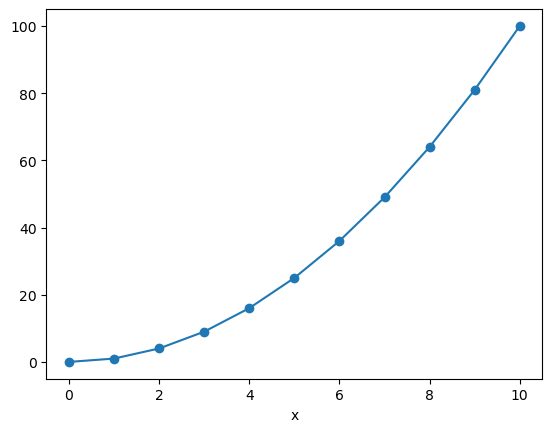

In [3]:
f.plot(marker='o')

In [4]:
f.sel(x=3)

<xarray.DataArray ()> Size: 8B
array(9)
Coordinates:
    x        int64 8B 3

We only have data on the integer points in x.
But what if we wanted to estimate the value at, say, 4.5?

In [5]:
f.sel(x=4.5)

KeyError: "not all values found in index 'x'. Try setting the `method` keyword argument (example: method='nearest')."

Interpolation to the rescue!

In [6]:
f.interp(x=4.5)

<xarray.DataArray ()> Size: 8B
array(20.5)
Coordinates:
    x        float64 8B 4.5

Interpolation uses [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) under the hood.
There are different modes of interpolation.

In [7]:
f.interp(x=4.5, method='linear').values

array(20.5)

In [8]:
f.interp(x=4.5, method='nearest').values

array(16.)

In [9]:
f.interp(x=4.5, method='cubic').values

array(20.25)

We can interpolate to a whole new set of coordinates at once:

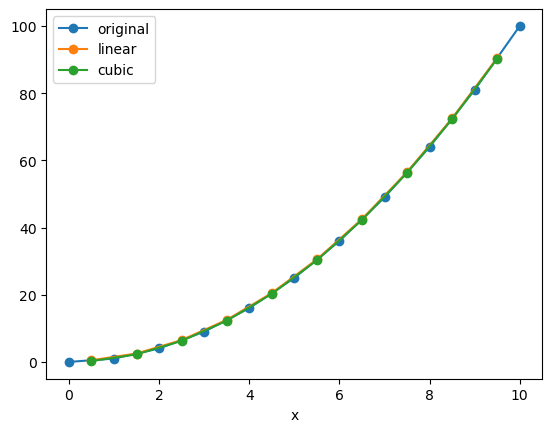

In [10]:
x_new = x_data + 0.5
f_interp_linear = f.interp(x=x_new, method='linear')
f_interp_cubic = f.interp(x=x_new, method='cubic')
f.plot(marker='o', label='original')
f_interp_linear.plot(marker='o', label='linear')
f_interp_cubic.plot(marker='o', label='cubic')
plt.legend()

Note that values outside of the original range are not supported:

In [11]:
f_interp_cubic.values

array([ 0.25,  2.25,  6.25, 12.25, 20.25, 30.25, 42.25, 56.25, 72.25,
       90.25,   nan])

```{note}
You can apply interpolation to any dimension, and even to multiple dimensions at a time.
(Multidimensional interpolation only supports `mode='nearest'` and `mode='linear'`.)
But keep in mind that `xarray` has no built-in understanding of geography.
If you use `interp` on lat / lon coordinates, it will just perform naive interpolation of the lat / lon values.
More sophisticated treatment of spherical geometry requires another package such as [xesmf](https://xesmf.readthedocs.io/).
```

## Loading Data from NetCDF Files

NetCDF (Network Common Data Format) is the most widely used format for distributing geoscience data. NetCDF is maintained by the [Unidata](https://www.unidata.ucar.edu/) organization.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):

>NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.
>
>NetCDF data is:
>
> - Self-Describing. A netCDF file includes information about the data it contains.
> - Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
> - Scalable. A small subset of a large dataset may be accessed efficiently.
> - Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
> - Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
> - Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.

`xarray` is designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)

Below we download and load some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset. The original file is located at https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz, but their server is non-responsive at the time of publication of this notebook. So we will use the mirror server from Zenodo. 

In [12]:
import pooch

In [13]:
gistemp_file = pooch.retrieve(
    'https://zenodo.org/records/13963679/files/gistemp1200_GHCNv4_ERSSTv5.nc',
    known_hash=None
)

SHA256 hash of downloaded file: f24422f16fcf86e194308603c989c5a9727d506a6f06125c9abf54b901b004e7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [14]:
ds = xr.open_dataset(gistemp_file)
ds

<xarray.Dataset> Size: 113MB
Dimensions:      (lat: 90, lon: 180, time: 1737, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-09-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 28kB ...
    tempanomaly  (time, lat, lon) float32 113MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-10-18 17:43:48 by SBBX_to_nc 2.0 - ILAND=1200,...

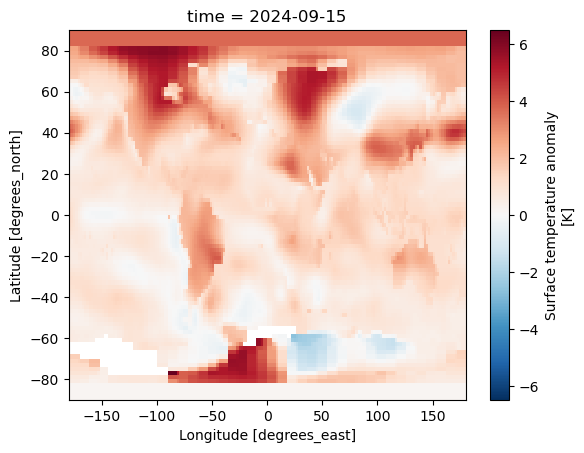

In [15]:
ds.tempanomaly.isel(time=-1).plot()
plt.show()

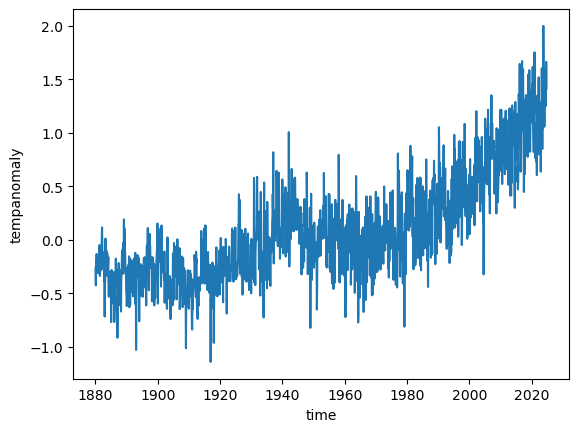

In [16]:
ds.tempanomaly.mean(dim=('lon', 'lat')).plot()
plt.show()

Let's visualize the temperature anomally for the grid near Worcester. (Worcester's coordinates: latitude: 42.2626; longtitude: -71.8023)

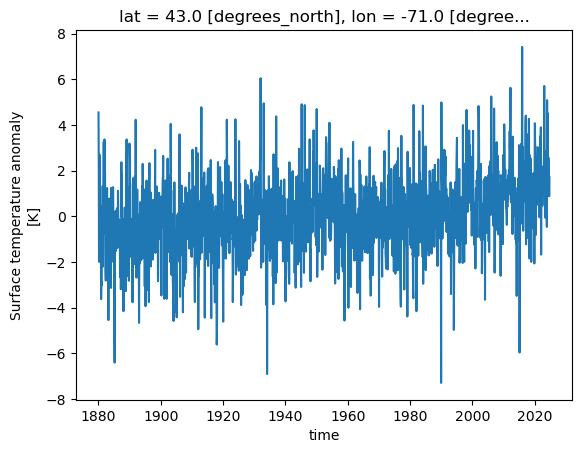

In [17]:
ds.tempanomaly.sel(lat=42.2626, lon=-71.8023, method='nearest').plot()
plt.show()

Note that you need to define `method` since the corresponding values for Worcester latitude and longitude do not exist in the `DataArray`'s coordinates. 

## Groupby

`xarray` copies `pandas'` very useful groupby functionality, enabling the "split / apply / combine" workflow on `xarray` `DataArray`s and `Dataset`s. In the first part of the lesson, we will learn to use groupby by analyzing sea-surface temperature data.


First we load a dataset. We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) product, a widely used and trusted gridded compilation of historical data going back to 1854.

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [18]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])

In [19]:
ds = ds.sel(time=slice('1960', '2022'))
ds

<xarray.Dataset> Size: 48MB
Dimensions:  (lat: 89, lon: 180, time: 756)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
Data variables:
    sst      (time, lat, lon) float32 48MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

Let's do some basic visualizations of the data, just to make sure it looks reasonable.

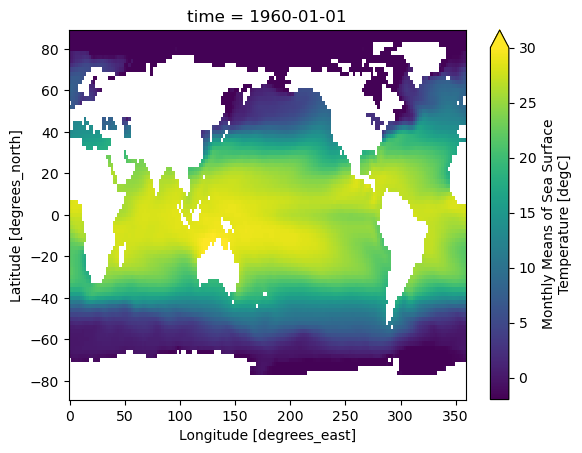

In [22]:
ds.sst.sel(time = '1960-01-01').plot(vmin=-2, vmax=30)
plt.show()

Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [23]:
ds.time

<xarray.DataArray 'time' (time: 756)> Size: 6kB
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 82088.]
    _ChunkSizes:      1

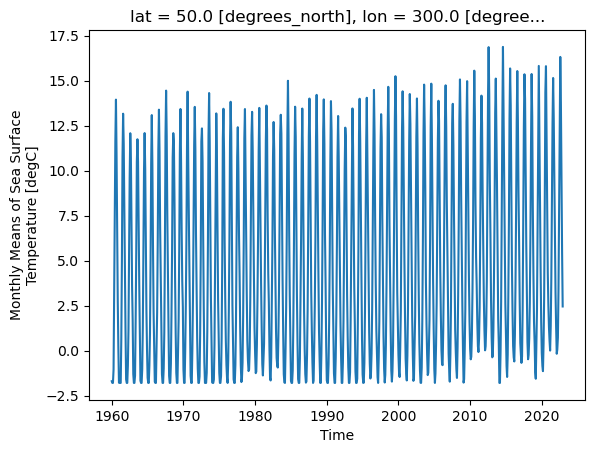

In [24]:
ds.sst.sel(lon=300, lat=50).plot()
plt.show()

As we can see from the plot, the timeseries at any one point is totally dominated by the seasonal cycle. We would like to remove this seasonal cycle (called the "climatology") in order to better see the long-term variaitions in temperature. We will accomplish this using **groupby**.

The syntax of `xarray`'s groupby is almost identical to `pandas`.
We will first apply groupby to a single `DataArray`.

### Split Step

The most important argument is `group`: this defines the unique values we will use to "split" the data for grouped analysis. We can pass either a `DataArray` or a name of a variable in the dataset. Lets first use a `DataArray`. Just like with `pandas`, we can use the time index to extract specific components of dates and times. `xarray` uses a special syntax for this `.dt`, called the `DatetimeAccessor`.

See a list of datatime properties you can access through .dt [here](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components)

In [25]:
ds.time.dt

In [26]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 756)> Size: 6kB
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
...
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 82088.]
    _ChunkSizes:      1

In [27]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 756)> Size: 6kB
array([1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
       1960, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961,
       1961, 1961, 1962, 1962, 1962, 1962, 1962, 1962, 1962, 1962, 1962,
       1962, 1962, 1962, 1963, 1963, 1963, 1963, 1963, 1963, 1963, 1963,
       1963, 1963, 1963, 1963, 1964, 1964, 1964, 1964, 1964, 1964, 1964,
       1964, 1964, 1964, 1964, 1964, 1965, 1965, 1965, 1965, 1965, 1965,
       1965, 1965, 1965, 1965, 1965, 1965, 1966, 1966, 1966, 1966, 1966,
       1966, 1966, 1966, 1966, 1966, 1966, 1966, 1967, 1967, 1967, 1967,
       1967, 1967, 1967, 1967, 1967, 1967, 1967, 1967, 1968, 1968, 1968,
       1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968, 1969, 1969,
       1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971,
       1971, 1972, 1972, 1972, 1972, 1972, 1972, 1972, 1972, 1972, 1972,
       1972, 1972, 1973, 1973, 1973, 1973, 1973, 1973, 1973, 1973, 1973,
       1973, 1973, 1973, 1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974,
       1974, 1974, 1974, 1974, 1975, 1975, 1975, 1975, 1975, 1975, 1975,
       1975, 1975, 1975, 1975, 1975, 1976, 1976, 1976, 1976, 1976, 1976,
       1976, 1976, 1976, 1976, 1976, 1976, 1977, 1977, 1977, 1977, 1977,
       1977, 1977, 1977, 1977, 1977, 1977, 1977, 1978, 1978, 1978, 1978,
...
       2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
       2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
       2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
       2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020,
       2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022,
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 82088.]
    _ChunkSizes:      1

We can use these arrays in a groupby operation:

In [28]:
gb = ds.sst.groupby(ds.time.dt.month)
gb

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12/12 groups present with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

`xarray` also offers a more concise syntax when the variable you're grouping on is already present in the dataset. This is identical to the previous line:

In [29]:
gb = ds.sst.groupby('time.month')
gb

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12/12 groups present with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

Now that the data are split, we can manually iterate over the group. The iterator returns the key (group name) and the value (the actual dataset corresponding to that group) for each group.

In [30]:
for group_name, group_da in gb:
    print(group_name) # stop after first iteration
    break
group_da

1


<xarray.DataArray 'sst' (time: 63, lat: 89, lon: 180)> Size: 4MB
[1009260 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 504B 1960-01-01 1961-01-01 ... 2022-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

### Map & Combine

Now that we have groups defined, it's time to "apply" a calculation to the group. Like in `pandas`, these calculations can either be:
- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, `xarray` will automatically combine the aggregated / transformed groups back into a single object.

```{warning}
Xarray calls the "apply" step `map`. This is different from Pandas!
```

In [31]:
gb.map?

Signature:
gb.map(
    func: 'Callable[..., DataArray]',
    args: 'tuple[Any, ...]' = (),
    shortcut: 'bool | None' = None,
    **kwargs: 'Any',
) -> 'DataArray'
Docstring:
Apply a function to each array in the group and concatenate them
together into a new array.

`func` is called like `func(ar, *args, **kwargs)` for each array `ar`
in this group.

Apply uses heuristics (like `pandas.GroupBy.apply`) to figure out how
to stack together the array. The rule is:

1. If the dimension along which the group coordinate is defined is
   still in the first grouped array after applying `func`, then stack
   over this dimension.
2. Otherwise, stack over the new dimension given by name of this
   grouping (the argument to the `groupby` function).

Parameters
----------
func : callable
    Callable to apply to each array.
shortcut : bool, optional
    Whether or not to shortcut evaluation under the assumptions that:

    (1) The action of `func` does not depend on any of the array
        metada

#### Aggregations

Like `pandas`, `xarray`'s groupby object has many built-in aggregation operations (e.g. `mean`, `min`, `max`, `std`, etc):

In [32]:
sst_mm = gb.mean(dim='time')
sst_mm

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)> Size: 769kB
array([[[-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7995719, -1.7996585, -1.7998686, ..., -1.7998053,
         -1.7996899, -1.7995679],
        [-1.799625 , -1.7997937, -1.800001 , ..., -1.800001 ,
         -1.7998347, -1.7996482],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

`.map` accepts as its argument a function. We can pass an existing function:

In [33]:
gb.map(np.mean)

<xarray.DataArray 'sst' (month: 12)> Size: 48B
array([13.679474, 13.787702, 13.784417, 13.704169, 13.662362, 13.736686,
       13.950283, 14.123172, 14.008736, 13.715602, 13.528554, 13.548446],
      dtype=float32)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Because we specified no extra arguments (like `axis`) the function was applied over all space and time dimensions. This is not what we wanted. Instead, we could define a custom function. This function takes a single argument --the group dataset-- and returns a new dataset to be combined:

In [34]:
def time_mean(a):
    return a.mean(dim='time')

sst_mm = gb.map(time_mean)
sst_mm

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)> Size: 769kB
array([[[-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7995719, -1.7996585, -1.7998686, ..., -1.7998053,
         -1.7996899, -1.7995679],
        [-1.799625 , -1.7997937, -1.800001 , ..., -1.800001 ,
         -1.7998347, -1.7996482],
        [-1.800001 , -1.800001 , -1.800001 , ..., -1.800001 ,
         -1.800001 , -1.800001 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

So we did what we wanted to do: calculate the climatology at every point in the dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_

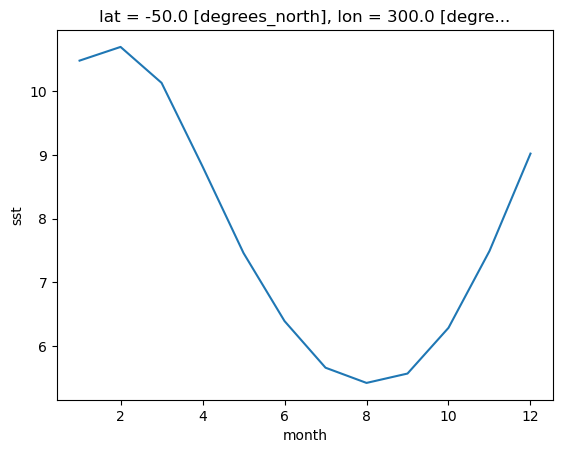

In [35]:
sst_mm.sel(lon=300, lat=-50).plot()
plt.show()

_Zonal Mean Climatology_

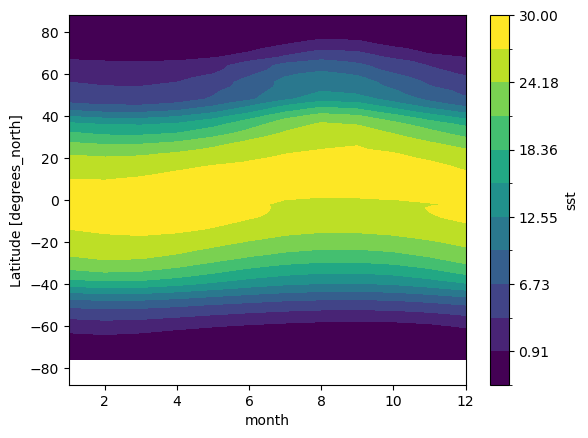

In [36]:
sst_mm.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30)
plt.show()

_Difference between January and July Climatology_

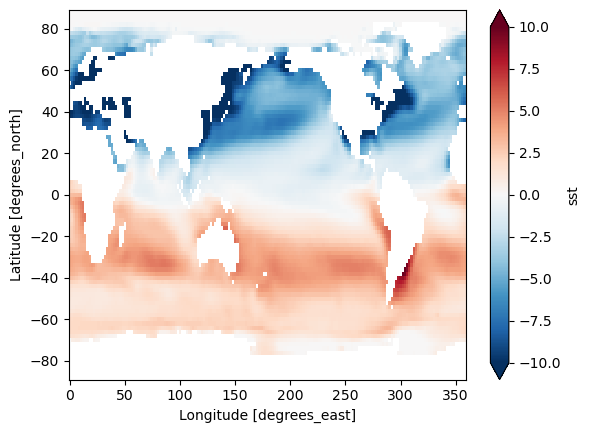

In [37]:
(sst_mm.sel(month=1) - sst_mm.sel(month=7)).plot(vmax=10)
plt.show()

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the residual, called the _anomaly_, which is the interesting part from a climate perspective.
Removing the seasonal climatology is a perfect example of a transformation: it operates over a group, but doesn't change the size of the dataset. Here is one way to code it.

In [38]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds.groupby('time.month').map(remove_time_mean)
ds_anom

<xarray.Dataset> Size: 48MB
Dimensions:  (time: 756, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
Data variables:
    sst      (time, lat, lon) float32 48MB 1.073e-06 1.073e-06 ... nan nan

```{note}
In the above example, we applied `groupby` to a `Dataset` instead of a `DataArray`.
```

Xarray makes these sorts of transformations easy by supporting _groupby arithmetic_.
This concept is easiest explained with an example:

In [39]:
gb = ds.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
ds_anom

<xarray.Dataset> Size: 48MB
Dimensions:  (lat: 89, lon: 180, time: 756)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 48MB 1.073e-06 1.073e-06 ... nan nan

Now we can view the climate signal without the overwhelming influence of the seasonal cycle.

_Timeseries at a single point in the North Atlantic_

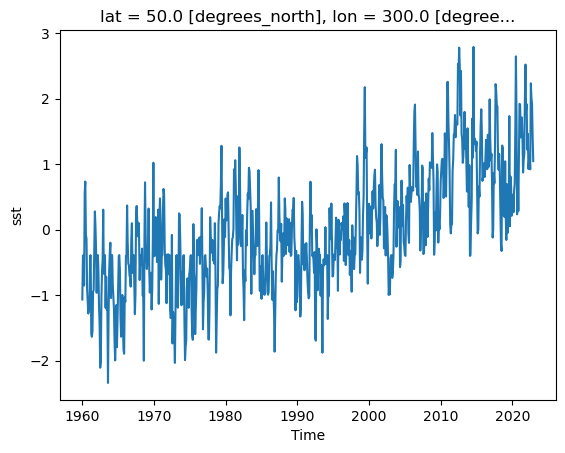

In [40]:
ds_anom.sst.sel(lon=300, lat=50).plot()
plt.show()

_Difference between Jan. 1 2022 and Jan. 1 1960_

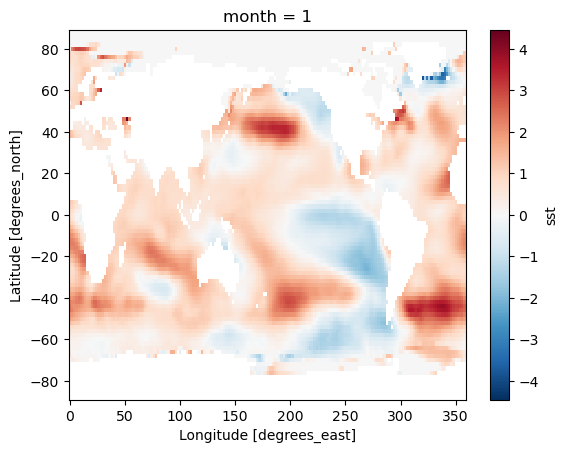

In [41]:
(ds_anom.sel(time='2022-01-01') - ds_anom.sel(time='1960-01-01')).sst.plot()
plt.show()

## Grouby-Related: Resample, Rolling, Coarsen

### Resample

[Resample](https://docs.xarray.dev/en/v2023.10.1/generated/xarray.Dataset.resample.html) in `xarray` is nearly identical to `pandas`.
**It can be applied only to time-index dimensions.** Here we compute the five-year mean.
It is effectively a group-by operation, and uses the same basic syntax.
Note that resampling changes the length of the the output array.

See the [list](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases) of string aliases for time series frequencies 

In [42]:
ds_anom_resample = ds_anom.resample(time='5YE').mean(dim='time')
ds_anom_resample

<xarray.Dataset> Size: 898kB
Dimensions:  (time: 14, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 112B 1960-12-31 1965-12-31 ... 2025-12-31
Data variables:
    sst      (time, lat, lon) float32 897kB -0.0004908 -0.0004653 ... nan nan

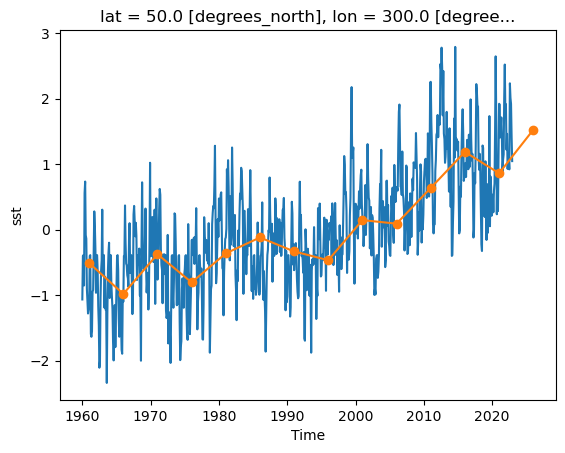

In [43]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o')
plt.show()

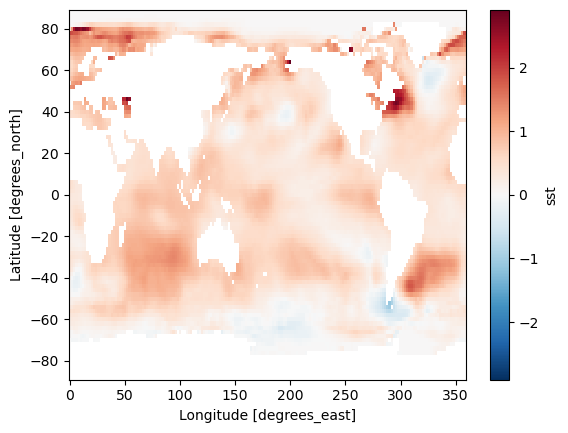

In [44]:
(ds_anom_resample.sel(time='2015-01-01', method='nearest') -
 ds_anom_resample.sel(time='1965-01-01', method='nearest')).sst.plot()
plt.show()

### Rolling

[Rolling](https://docs.xarray.dev/en/v2023.10.1/generated/xarray.Dataset.rolling.html#xarray.Dataset.rolling) is also similar to `pandas`.
It does not change the length of arrays.
Instead, it allows a moving window to be applied to the data at each point.

In [45]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

<xarray.Dataset> Size: 48MB
Dimensions:  (lat: 89, lon: 180, time: 756)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2022-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 48MB nan nan nan nan ... nan nan nan nan

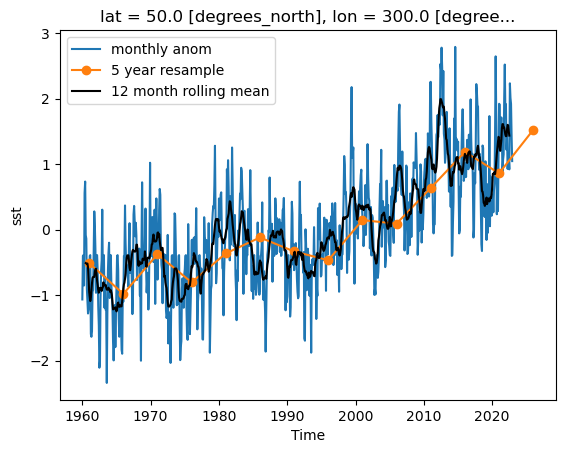

In [46]:
ds_anom.sst.sel(lon=300, lat=50).plot(label='monthly anom')
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o', label='5 year resample')
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label='12 month rolling mean', color='k')
plt.legend()
plt.show()

## Coarsen

Coarsen is a simple way to reduce the size of your data along one or more axes.
It is very similar to `resample` when operating on time dimensions; the key difference is that coarsen only operates on fixed blocks of data, irrespective of the coordinate values, while resample actually looks at the coordinates to figure out, e.g. what month a particular data point is in. 

For regularly-spaced monthly data beginning in January, the following should be equivalent to annual resampling.
However, results would be different for irregularly-spaced data.

In [47]:
ds.coarsen(time=12, boundary = 'exact').mean()

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 63, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 504B 1960-06-16T08:00:00 ... 2022-06-16T12...
Data variables:
    sst      (time, lat, lon) float32 4MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

Coarsen also works on spatial coordinates (or any coordiantes).

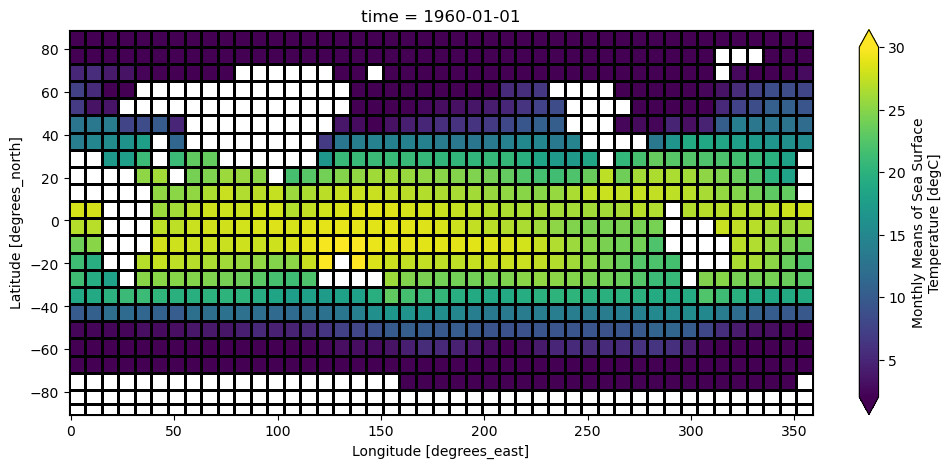

In [48]:
ds_coarse = ds.coarsen(lon=4, lat=4, boundary='pad').mean()
ds_coarse.sst.isel(time=0).plot(vmin=2, vmax=30, figsize=(12, 5), edgecolor='k')
plt.show()